In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Wed Aug 13 08:15:24 PDT 2025
lutzes
/mnt/share/homes/lutzes/vivarium_research_alzheimers/verification_and_validation


## V&V List from Docs 
- Verify that all simulants in the model have AD (i.e., all recorded person-time is in the “AD” state, not the “susceptible” state)
- Verify that there are no transitions between AD states during the simulation (since it’s an SI model and all simulants should be in the I state the whole time)
- Verify ACMR against GBD
- Validate Alzheimer’s CSMR against GBD
- Validate Alzheimer’s EMR against GBD
- Validate Alzheimer’s YLLs and YLDs against GBD
- Verify the number of new simulants per year against the AD population model
- Use interactive sim to verify initial population structure against the AD population model
- For comparison with model 1, calculate total “real world” Alzheimer’s population over time (I’m not sure how closely we expect this to match model 1)

# Load Data

In [2]:
locations = ['united_states_of_america', 'china']

results_dir_prefix = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

results_dirs = [
    results_dir_prefix + 'results/model2.1/united_states_of_america/2025_08_12_11_59_42/results/',
    results_dir_prefix + 'results/model2.1/china/2025_08_12_12_17_46/results/'
]

artifact_dirs = [results_dir_prefix + 'artifacts/model1.0/' + x + '.hdf' for x in locations]
artifact_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model1.0/united_states_of_america.hdf',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model1.0/china.hdf']

In [3]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [4]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0], filter_terms = ['year_start==2021'])

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end
age_dictionary.head()

,age_group_id,age_group_name,age_group,age_start,age_end
0,11,30 to 34,30_to_34,30.0,35.0
1,12,35 to 39,35_to_39,35.0,40.0
2,13,40 to 44,40_to_44,40.0,45.0
3,14,45 to 49,45_to_49,45.0,50.0
4,15,50 to 54,50_to_54,50.0,55.0


## Verify that all simulants in the model have AD 

In [5]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [6]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

Yay!

## Verify that there are no transitions between AD states during the simulation 

In [7]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [8]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

Woohoo!

## Verify ACMR against artifact

In [9]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_acmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum()

    deaths = load_df('deaths')
    deaths = deaths.groupby(cols).sum()

    acmr = (deaths / total_pt)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_acmr = calculate_acmr()

/tmp/ipykernel_3771761/3885451193.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_pt = person_time_total.groupby(cols).sum()
/tmp/ipykernel_3771761/3885451193.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deaths = deaths.groupby(cols).sum()


In [10]:
art_acmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
    data = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data = data.merge(age_dictionary, on=['age_start','age_end'])
    data = data.loc[data['age_group_id'].isin(age_group_ids)]
    data['measure'] = 'acmr'
    data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_acmr = pd.concat([art_acmr, data])
#art_acmr.head()

In [11]:
def age_group_plot(measure, sim_data, art_data):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == '2025') & (sim_data.sex == sex)]
            art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex)]

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} in 2025")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

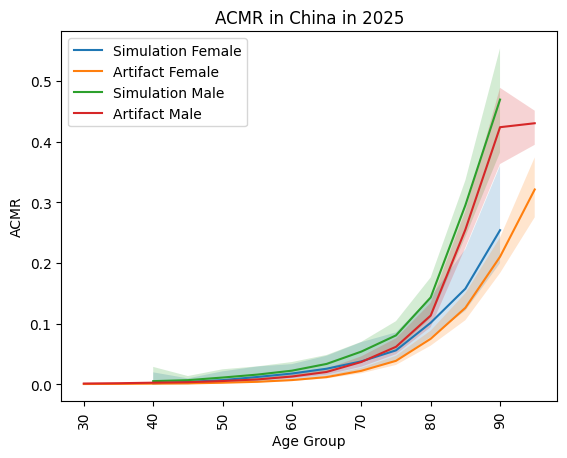

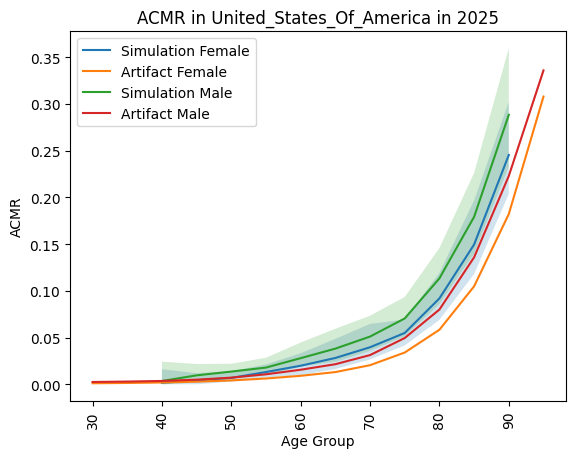

<Figure size 640x480 with 0 Axes>

In [12]:
age_group_plot('ACMR', sim_acmr, art_acmr)

In [13]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

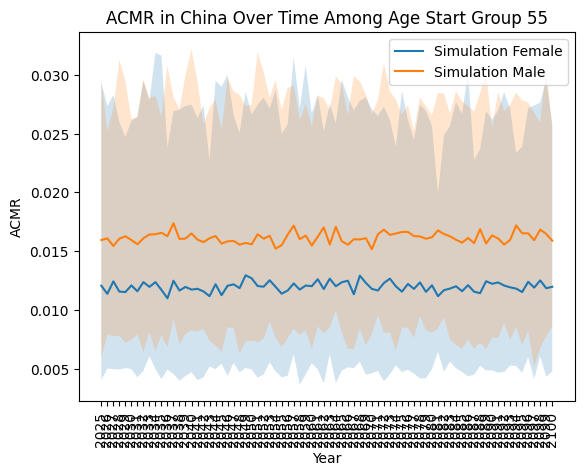

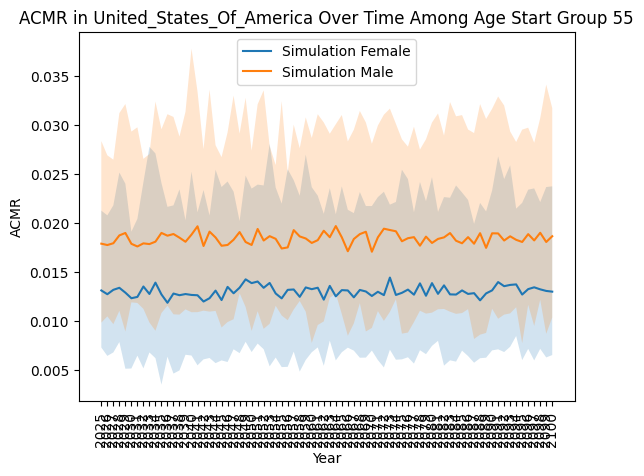

<Figure size 640x480 with 0 Axes>

In [14]:
over_time_plot('ACMR', sim_acmr, 55)

## Validate Alzheimer’s CSMR against artifact

In [15]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_csmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum()

    deaths = load_df('deaths')
    deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    acmr = (deaths / total_pt)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_csmr = calculate_csmr()

/tmp/ipykernel_3771761/3981298958.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_pt = person_time_total.groupby(cols).sum()
/tmp/ipykernel_3771761/3981298958.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()


In [16]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [17]:
art_csmr = load_artifact_cause_data('cause_specific_mortality_rate')
#art_csmr.head()

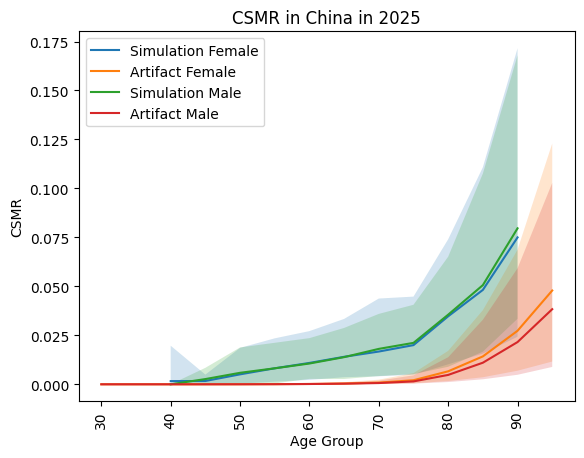

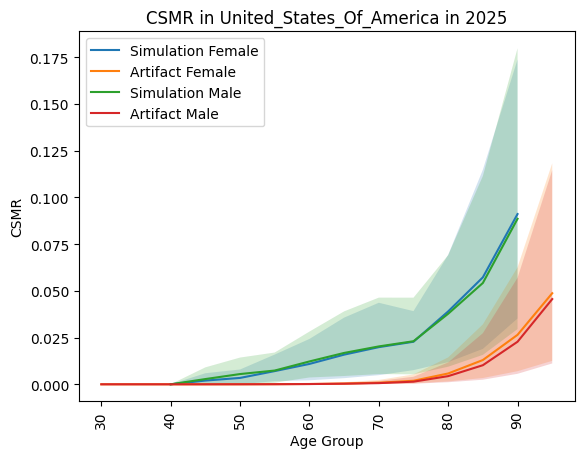

<Figure size 640x480 with 0 Axes>

In [18]:
age_group_plot('CSMR', sim_csmr, art_csmr)

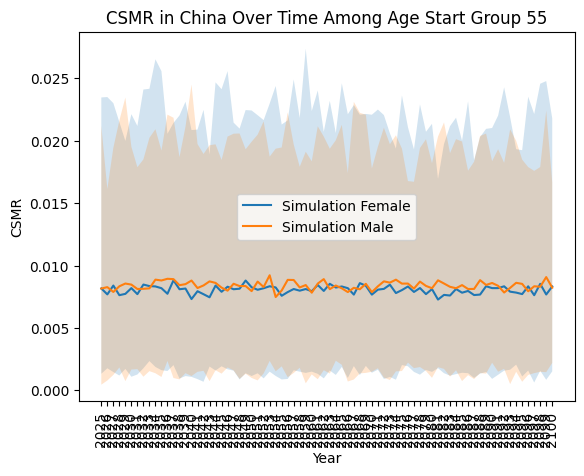

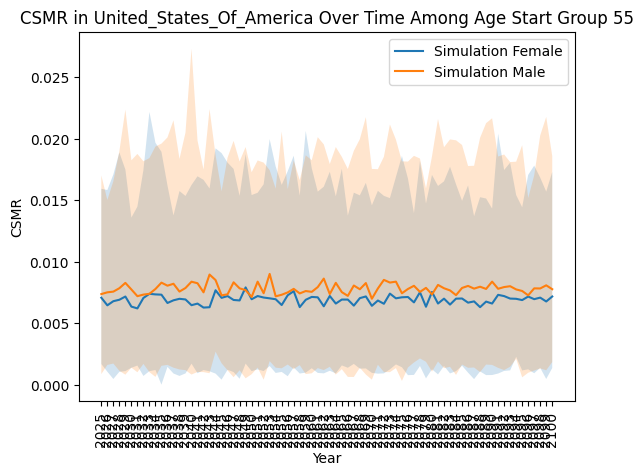

<Figure size 640x480 with 0 Axes>

In [19]:
over_time_plot('CSMR', sim_csmr, 55)

## Validate Alzheimer’s EMR against GBD

In [20]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    deaths = load_df('deaths')
    deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    acmr = (deaths / infected)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_emr = calculate_emr()

/tmp/ipykernel_3771761/82446670.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  infected = person_time_total.loc[person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()
/tmp/ipykernel_3771761/82446670.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()


In [21]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
#art_emr.head()

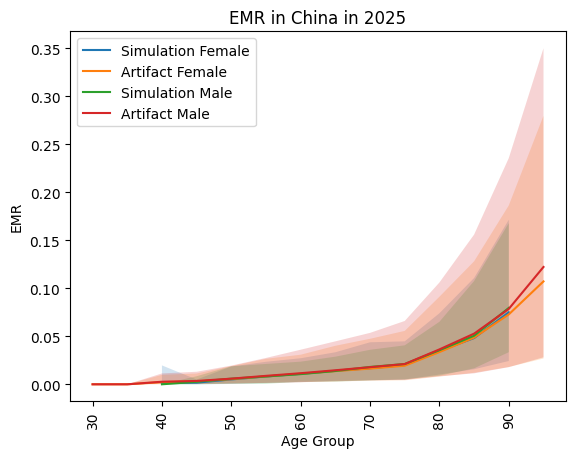

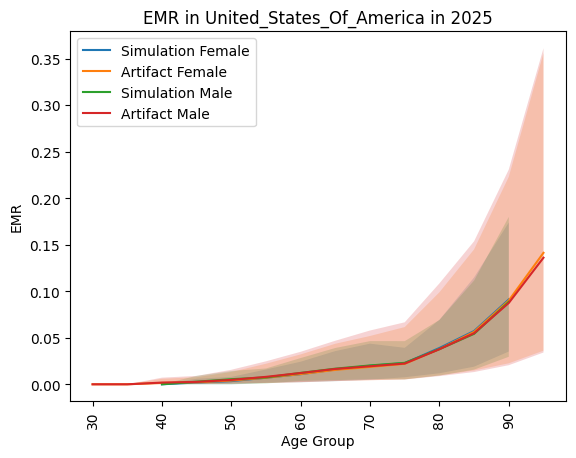

<Figure size 640x480 with 0 Axes>

In [22]:
age_group_plot('EMR', sim_emr, art_emr)

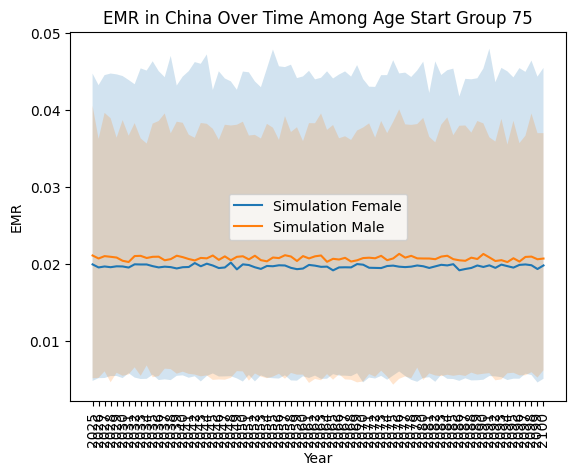

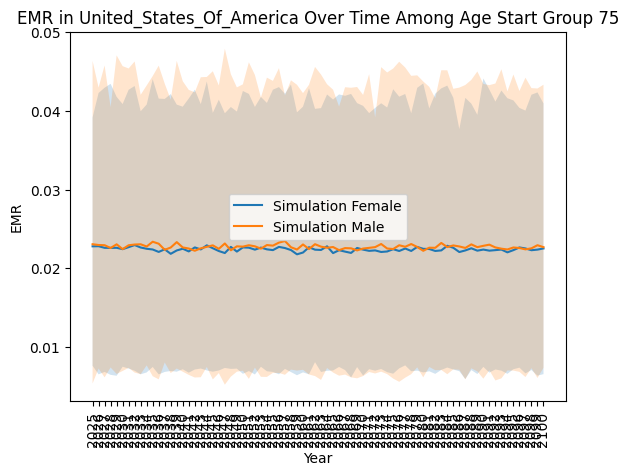

<Figure size 640x480 with 0 Axes>

In [23]:
over_time_plot('EMR', sim_emr, 75)

## Validate Alzheimer’s YLLs and YLDs against GBD

In [24]:
sex_ids = [1,2]
location_ids = [6,102]

gbd_data = get_outputs(topic='cause',
                      year_id=2021,
                      sex_id=sex_ids,
                      age_group_id=age_group_ids,
                      location_id=location_ids,
                      cause_id=543,
                      measure_id=[3,4],
                      metric_id=3,
                      release_id=9)
gbd_data['measure'] = gbd_data.measure_name.str.split(' ', expand=True)[0].str.lower()
gbd_data['location_name'] = gbd_data.location_name.str.replace(' ', '_').str.title()
gbd_data = gbd_data.merge(age_dictionary, on=['age_group_id','age_group_name'])
#gbd_data.head()

/ihme/homes/lutzes/.conda/envs/mncnh_vv/lib/python3.11/site-packages/ihme_cc_rules_client/lib/rules_manager.py:167: UnrecognizedRuleWarning: Rules API returned unrecognized rule: COD_PASS_GET_RESULTS_TO_GET_ESTIMATES. The installed ihme_cc_rules_client package (version 4.0.2) is likely outdated and should be upgraded. If you see this warning in a central environment, please submit a Help Desk ticket for Central Comp: https://helpdesk.ihme.washington.edu
  warnings.warn(


In [25]:
cols = ['input_draw','current_year','location','age_group','sex','measure']

def calculate_ylls_ylds():
    ylls = load_df('ylls')
    ylls = ylls.loc[ylls.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()#['value'].reset_index()

    ylds = load_df('ylds')
    ylds = ylds.loc[ylds.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()#['value'].reset_index()

    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby([c for c in cols if c != 'measure']).sum()

    ylls = (ylls / total_pt)[['value']].reset_index()
    ylds = (ylds / total_pt)[['value']].reset_index()

    combine = pd.concat([ylls, ylds], ignore_index=True)
    combine = combine.merge(age_dictionary, on=['age_group'])
    combine = combine.loc[combine['age_group_id'].isin(age_group_ids)]
    combine = combine.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return combine

sim_yll_yld = calculate_ylls_ylds()

/tmp/ipykernel_3771761/4064126926.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ylls = ylls.loc[ylls.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()#['value'].reset_index()
/tmp/ipykernel_3771761/4064126926.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ylds = ylds.loc[ylds.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()#['value'].reset_index()
/tmp/ipykernel_3771761/4064126926.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify n

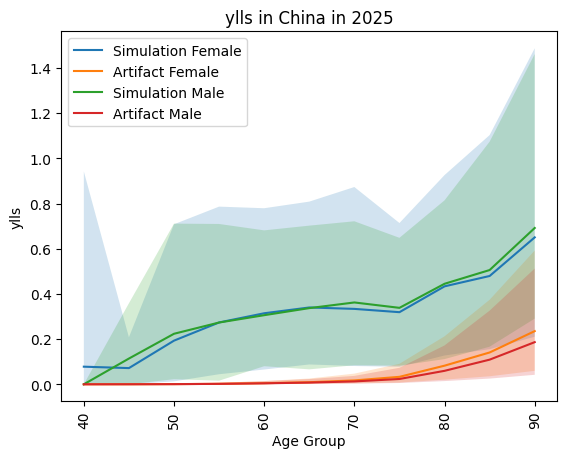

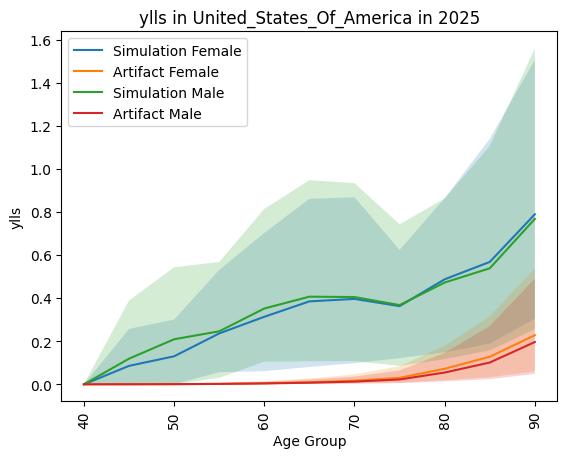

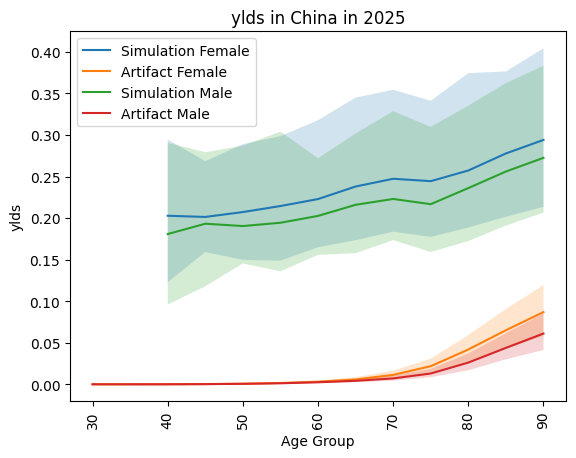

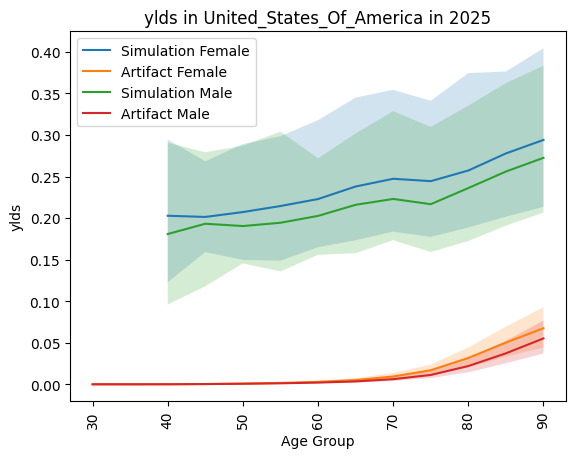

<Figure size 640x480 with 0 Axes>

In [26]:
for measure in ['ylls', 'ylds']:
    for location in sim_yll_yld.location.unique():
        for sex in sim_yll_yld.sex.unique():
            plot_data = sim_yll_yld.loc[(sim_yll_yld.location == location) & (sim_yll_yld.current_year == '2025') & (sim_yll_yld.sex == sex) & (sim_yll_yld.measure == measure)]
            art_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == measure)]

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['val'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"{measure} in {location} in 2025")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

Same issues observed with YLDs from model 1. Not surprising that we continue to see them since we did not fix it. 

## Verify the number of new simulants per year against the AD population model

In [27]:
## scale = 100_000 (size of initial pop) / [X real = prevalence (artifact) * population totals (artifact pop structure)]

In [28]:
## Take my new sims from the sim output and multiply by scale (shown above) 
## This should match GBD incidence counts 
## Could also compare to counts with artifact * population 

In [ ]:
sex_ids = [1,2]
location_ids = [6,102]

gbd_data = get_outputs(topic='cause',
                      year_id=2021,
                      sex_id=sex_ids,
                      age_group_id=age_group_ids,
                      location_id=location_ids,
                      cause_id=543,
                      measure_id=[5,6],
                      metric_id=1,
                      release_id=9)
gbd_data['measure'] = gbd_data.measure_name.str.split(' ', expand=True)[0].str.lower()
gbd_data['location_name'] = gbd_data.location_name.str.replace(' ', '_').str.title()
gbd_data = gbd_data.merge(age_dictionary, on=['age_group_id','age_group_name'])
#gbd_data.head()

/ihme/homes/lutzes/.conda/envs/mncnh_vv/lib/python3.11/site-packages/ihme_cc_rules_client/lib/rules_manager.py:167: UnrecognizedRuleWarning: Rules API returned unrecognized rule: COD_PASS_GET_RESULTS_TO_GET_ESTIMATES. The installed ihme_cc_rules_client package (version 4.0.2) is likely outdated and should be upgraded. If you see this warning in a central environment, please submit a Help Desk ticket for Central Comp: https://helpdesk.ihme.washington.edu
  warnings.warn(


,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,...,measure,measure_name,metric_name,sex,val,upper,lower,age_group,age_start,age_end
0,11,543,102,5,1,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,prevalence,Prevalence,Number,Male,0.0,0.0,0.0,30_to_34,30.0,35.0
1,11,543,102,5,1,2,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,prevalence,Prevalence,Number,Female,0.0,0.0,0.0,30_to_34,30.0,35.0
2,11,543,102,6,1,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,incidence,Incidence,Number,Male,0.0,0.0,0.0,30_to_34,30.0,35.0
3,11,543,102,6,1,2,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,incidence,Incidence,Number,Female,0.0,0.0,0.0,30_to_34,30.0,35.0
4,11,543,6,5,1,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,prevalence,Prevalence,Number,Male,0.0,0.0,0.0,30_to_34,30.0,35.0


In [30]:
inc = art.load('cause.alzheimers_disease_and_other_dementias.prevalence')
inc = (inc.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean']).reset_index())
inc['mean'].sum()

2.647011531454292

In [68]:
prev = (art.load('cause.alzheimers_disease_and_other_dementias.prevalence') * art.load('population.structure').values).sum().mean()
prev

16990827.320188835

In [85]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.title()
    prev = (art.load('cause.alzheimers_disease_and_other_dementias.prevalence') * art.load('population.structure').values).sum().mean()

    ratio = 100_000 / prev
    temp['ratio'] = ratio

    # pop = art.load('population.structure').reset_index()
    # pop = pop.rename(columns={'value': 'population'})
    # total_pop = pop['population'].sum()

    # # Make this a population weighted (or crude) prevalence 
    # prev = art.load('cause.alzheimers_disease_and_other_dementias.prevalence')
    # prev = (prev.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
    #         .filter(['mean']).reset_index())
    # # prev = prev['mean'].sum()

    # ## Merge prev and pop and add a new column that is the multiplication of population and prevalence
        

    # # ratio = 20_000 / (total_pop * prev)  #total_pop * inc / 10_000

    # temp['ratio'] = ratio
    # temp['scalar'] = (temp['population']) * ratio
    # temp['scalar'] = temp['scalar'].replace([np.inf, -np.inf], 0)
    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
scale#.head()

,location,sex,age_start,age_end,current_year,year_end,value,ratio,age_group_id,age_group_name,age_group
0,United_States_Of_America,Female,30.0,35.0,2021,2022,1.147451e+07,0.020506,11,30 to 34,30_to_34
1,United_States_Of_America,Male,30.0,35.0,2021,2022,1.150887e+07,0.020506,11,30 to 34,30_to_34
2,United_States_Of_America,Female,35.0,40.0,2021,2022,1.110377e+07,0.020506,12,35 to 39,35_to_39
3,United_States_Of_America,Male,35.0,40.0,2021,2022,1.097230e+07,0.020506,12,35 to 39,35_to_39
4,United_States_Of_America,Female,40.0,45.0,2021,2022,1.061399e+07,0.020506,13,40 to 44,40_to_44
5,United_States_Of_America,Male,40.0,45.0,2021,2022,1.039491e+07,0.020506,13,40 to 44,40_to_44
6,United_States_Of_America,Female,45.0,50.0,2021,2022,9.980039e+06,0.020506,14,45 to 49,45_to_49
7,United_States_Of_America,Male,45.0,50.0,2021,2022,9.710821e+06,0.020506,14,45 to 49,45_to_49
8,United_States_Of_America,Female,50.0,55.0,2021,2022,1.063355e+07,0.020506,15,50 to 54,50_to_54
9,United_States_Of_America,Male,50.0,55.0,2021,2022,1.032785e+07,0.020506,15,50 to 54,50_to_54


In [86]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio']], on= ['location','sex','age_group'])
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum()
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims#.head()

/tmp/ipykernel_3771761/923201765.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_sims = new_sims.groupby(cols).sum()


,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,China,30_to_34,Female,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
1,2025,China,30_to_34,Male,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,30_to_34,Female,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
3,2025,United_States_Of_America,30_to_34,Male,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
4,2026,China,30_to_34,Female,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,2099,United_States_Of_America,90_to_94,Male,25.0,38019.763904,6889.421719,26674.889507,27347.857469,37500.895852,55085.841293,57836.232094,32,90 to 94,90.0,95.0
3948,2100,China,90_to_94,Female,25.0,171743.282552,32903.728917,115197.809231,116828.928654,168549.007016,250852.574555,263187.915190,32,90 to 94,90.0,95.0
3949,2100,China,90_to_94,Male,25.0,46235.439304,8629.478222,31263.122269,32384.516872,45195.600672,67011.822951,69152.667193,32,90 to 94,90.0,95.0
3950,2100,United_States_Of_America,90_to_94,Female,25.0,74771.617154,13035.758455,51838.039390,53096.196884,72904.862547,107323.760196,112795.282322,32,90 to 94,90.0,95.0


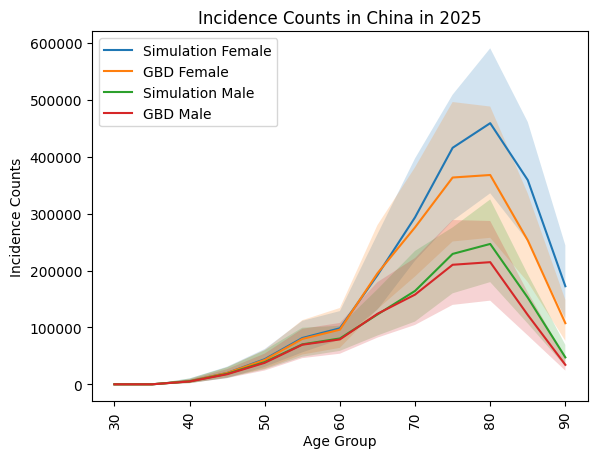

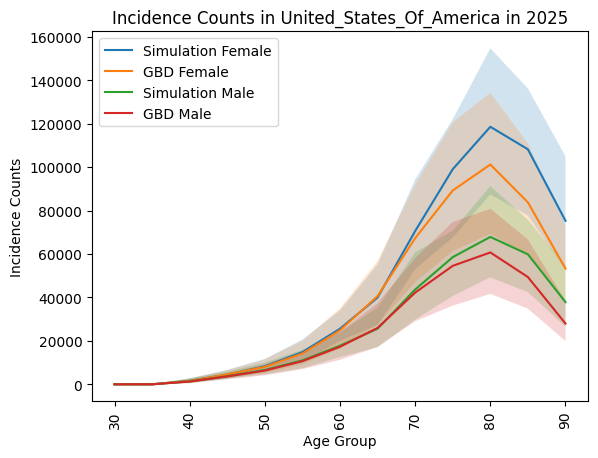

<Figure size 640x480 with 0 Axes>

In [88]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == '2025') & (new_sims.sex == sex) ]
        art_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'incidence')]

        plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
        plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

        plt.plot(art_plot.age_start, art_plot['val'], label=f'GBD {sex}')
        plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

        plt.title(f"Incidence Counts in {location} in 2025")
        plt.tick_params(axis='x', labelrotation=90)
        plt.xlabel("Age Group")
        plt.ylabel(f"Incidence Counts")
        plt.legend()
    plt.figure()

## Total Population Over Time 

In [35]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,China,25.0,102784.463901,448.291651,101790.587269,101800.206982,102830.217659,103362.809035,103389.864476
1,2025,United_States_Of_America,25.0,102587.540370,455.603340,101623.745380,101790.887885,102631.811088,103170.615195,103175.425051
2,2026,China,25.0,112467.866940,2132.861397,107759.318275,107828.459959,112751.548255,115182.629979,115237.642710
3,2026,United_States_Of_America,25.0,111344.444846,2115.686131,107078.422998,107570.531417,112019.047228,114006.720329,114079.770021
4,2027,China,25.0,120978.186119,3719.091449,112736.016427,112901.956468,121457.388090,125674.830390,125686.554415


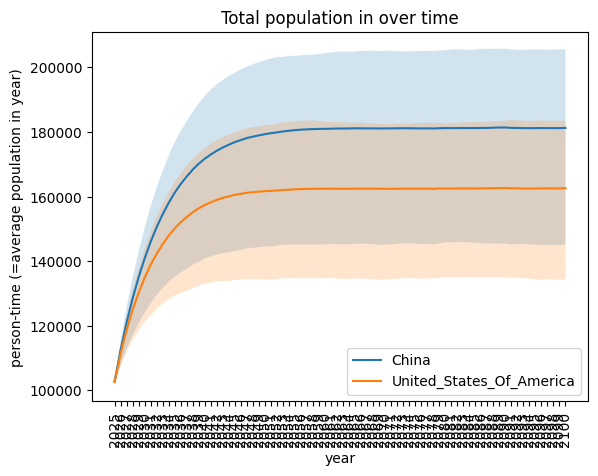

In [36]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Total population in over time")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("person-time (=average population in year)")
    plt.legend()